In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
import tqdm
import json
import joblib
import datetime
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, clone
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm

import catboost as cb
# import lightgbm as lgbm

from utils import load_config
from src.helpers import (
    ContiguousGroupKFold, 
    ContiguousTimeSeriesSplit,
    custom_log_likelihood, 
    compute_per_station_metrics, 
    get_station_stats, 
    standardize_values, 
    standardize_prediction_intervals, 
    compute_per_station_metrics, 
    summarize_metrics,
    compute_non_negative_log_likelihood,
    GroupMinMaxScaler,
    GroupStandardScaler
)

## Constants

In [4]:
config = load_config()

In [5]:
DATA_DIR = config['final_data']
TRAIN = os.path.join(DATA_DIR, 'train.csv')
TEST = os.path.join(DATA_DIR, 'eval.csv')

## Modelling

- Direct Regressor: Predicts outputs and prediction interval directly
  - GBT with quantile loss
  - deep learning with quantile loss
- Ensemble Regressor: Uses a monte-carlo simulation to generate prediction interval
  - GBT with ensemble
  - deep learning with ensemble
- CV ensemble modelling - fold cross validation

In [6]:
CV_SPLIT = 5

#### Load data

In [7]:
df = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)

/tmp/ipykernel_1062651/1427115751.py:1: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN)
/tmp/ipykernel_1062651/1427115751.py:2: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(TEST)


In [8]:
CATEGORICAL = ['river', 'location', 'month', 'week', 'season', 'station_code']

In [9]:
for col in CATEGORICAL:
    df[col] = df[col].astype('str')
    df_test[col] = df_test[col].astype('str')

In [10]:
NUM_LOCATION = ['lat', 'lon', 'altitude']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
COLS_TO_DROP = ['ObsDate', 'catchment', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector', 
    'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone']
TARGET_COLS = ['water_flow_week_1', 'water_flow_week_2', 'water_flow_week_3', 'water_flow_week_4']
LAG_COLS = ['water_flow_lag_1w', 'water_flow_lag_2w', 'water_flow_rolling_mean_4w']
CONTINUOUS_COLS = list(df.select_dtypes(['float', 'int']).drop(columns = TARGET_COLS + COLS_TO_DROP + LAG_COLS, errors = 'ignore').columns)

### Train Test Split
- Based on previous analysis, the dataset exhibits annual seasonality but no significant long-term trend.
- Therefore, it is acceptable to use chronological or block-wise splits without always reserving the most recent data for validation.
- This approach is appropriate for seasonally-repeating time series, where the assumption of trend-driven data drift does not hold.
- In such cases, the model's ability to generalize across seasonal cycles is more important than strict recency.

In [11]:
cgkf = ContiguousGroupKFold(5)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1990 1991 1992
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1993 1994 1995
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1999 2000 2001 2002 2003 2004
Validation: 1996 1997 1998
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 2002 2003 2004
Validation: 1999 2000 2001
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------


In [12]:
cgkf = ContiguousTimeSeriesSplit(5, 0.6)#, test_size = 2)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validation: 1999 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
Validation: 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
Validation: 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
Validation: 2003 2004
-------------------------------------------------------------------------


### Models

In [13]:
class ChainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, estimator_params, n_targets = None, chained = True):
        self.base_estimator = base_estimator
        self.estimator_params = estimator_params
        self.chained = chained
        self.n_targets = n_targets
        self.models_ = []

    def fit(self, X, y, eval_set=None, **fit_params):
        # X = np.array(X)
        # Y = np.array(y)
        self.models_ = []

        self.n_targets = y.shape[1]

        X_val, Y_val = None, None
        if eval_set:
            X_val, Y_val = eval_set[0]
            # X_val = np.array(X_val)
            # Y_val = np.array(Y_val)

        X_train_chain = X.copy()
        X_val_chain = X_val.copy() if eval_set else None

        for i in range(self.n_targets):
            params = self.estimator_params.copy()
            model = self.base_estimator(**params)
            y_train_i = y.iloc[:, i]

            # Resolve fit parameters (per target if needed)
            local_fit_params = {}
            for k, v in fit_params.items():
                if isinstance(v, (list, tuple)) and len(v) == self.n_targets:
                    local_fit_params[k] = v[i]
                else:
                    local_fit_params[k] = v

            if eval_set:
                y_val_i = Y_val.iloc[:, i]
                model.fit(
                    X_train_chain, y_train_i,
                    eval_set=[(X_val_chain, y_val_i)],
                    **local_fit_params
                )
            else:
                model.fit(X_train_chain, y_train_i, **local_fit_params)

            self.models_.append(model)
            if self.chained:
                y_pred_train = model.predict(X_train_chain).reshape(-1, 1)
                X_train_chain[f'pred_{i}'] = y_pred_train #np.hstack([X_train_chain, y_pred_train])

                if eval_set:
                    y_pred_val = model.predict(X_val_chain).reshape(-1, 1)
                    X_val_chain[f'pred_{i}'] = y_pred_val #np.hstack([X_val_chain, y_pred_val])

        return self

    def predict(self, X):
        X = np.array(X)
        X_chain = X.copy()
        preds = []

        for model in self.models_:
            y_pred = model.predict(X_chain).reshape(-1, 1)
            preds.append(y_pred)
            X_chain = np.hstack([X_chain, y_pred])

        return np.hstack(preds)

    def save_model(self, path):
        """Save the chained model to disk."""
        os.makedirs(path, exist_ok=True)

        meta = {
            'n_targets': self.n_targets,
            'estimator_params': self.estimator_params,
            'chained': self.chained,
            'model_paths': []
        }

        for idx, model in enumerate(self.models_):
            model_path = os.path.join(path, f"catboost_target_{idx}.cbm")
            model.save_model(model_path)
            meta['model_paths'].append(f"catboost_target_{idx}.cbm")

        with open(os.path.join(path, "metadata.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load_model(cls, path, base_estimator):
        """Load the chained model from disk."""
        with open(os.path.join(path, "metadata.json")) as f:
            meta = json.load(f)

        model = cls(base_estimator = base_estimator, estimator_params = meta['estimator_params'], chained = meta['chained'], n_targets=meta['n_targets'])
        model.models_ = []

        for model_file in meta['model_paths']:
            # cbm = clone(base_estimator)
            cbm = base_estimator()#**self.estimator_params)
            cbm.load_model(os.path.join(path, model_file))
            model.models_.append(cbm)

        return model

    def get_best_iter(self):
        return np.array([model.best_iter for model in self.models_])


In [14]:
def create_gbt_model(model_type = 'catboost', model_params = {}, chained = True):
    if model_type == 'catboost':
        base_model = cb.CatBoostRegressor#(*args, **kwargs)
    elif model_type == 'lightgbm':
        # base_model = lgbm.LGBMRegressor(*args, **kwargs)
        raise NotImplementedError
    elif model_type == 'xgboost':
        # base_model = xgb.XGBRegressor(*args, **kwargs)
        raise NotImplementedError
    else:
        raise ValueError('Unsupported model type')
    model = ChainedRegressor(base_model, model_params, chained = chained)
    return model
        

In [15]:
class BaseRegressor(ABC):
    def __init__(
        self, 
        model_fn = None, 
        model_params = None, 
        preprocessor = None, 
        cv = 5, 
        cv_group = 'year', 
        alphas = [0.05, 0.95], 
        method = 'indirect',
        n_models = 5,
        cat_features = None,
        exclude_cols = None,
        random_state = 42,
        bootstrap = True,
        delta = 0.01,
        patience = 5,
        split_type = 'time_series'
    ):
        self.model_fn = model_fn
        self.model_params = model_params
        self.preprocessor = preprocessor
        self.cv = cv
        self.cv_group = cv_group
        self.alphas = alphas
        self.method = method
        self.n_models = n_models
        self.cat_features = cat_features[::] if cat_features is not None else None
        self.exclude_cols = exclude_cols
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.delta = delta
        self.patience = patience
        self.split_type = split_type
        # if self.model_params is not None:
        #     self.lr = self.model_params.pop('lr') if 'lr' in self.model_params.keys() else 0.01

        self.preprocessors = {}
        self.models = {}
        self.history = {}

    @abstractmethod
    def fit(self, X, y):           
        raise NotImplementedError

    @abstractmethod
    def predict(self, X):
        raise NotImplementedError

    @abstractmethod
    def save_model(self, save_path):
        raise NotImplementedError

    @abstractmethod
    def load_model(self, load_path):
        raise NotImplementedError

    @abstractmethod
    def prep_data_for_model(self, X):
        raise NotImplementedError

    def get_data(self, X, y, train_ids, val_ids):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        return X_train, X_val, y_train, y_val

    def cv_split(self, X, group):
        if self.split_type == 'time_series':
            cvf = ContiguousTimeSeriesSplit(self.cv, 0.6)
        elif self.split_type == 'group_kfold':
            cvf = ContiguousGroupKFold(self.cv)
        else:
            raise ValueError('`split_type` must be one of `time_series` or `group_kfold`')
        return cvf.split(X, groups = group)
        

In [16]:
class GBTEnsembleRegressor(BaseRegressor):
    def __init__(self, *args, model_type = 'catboost', lr = None, k = 12, chained = True, use_priors = False, enforce_location = True, location_column = None, min_patience = 20, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        if self.lr is not None:
            if self.method == 'direct':
                assert len(self.lr) == 3, '`len(lr)` must be 3 if method = direct'
            elif self.method == 'indirect':
                assert len(self.lr) == self.n_models, '`len(lr)` must be same as n_models'
        self.model_type = model_type
        self.chained = chained
        self.use_priors = use_priors
        self.enforce_location = enforce_location
        self.location_column = location_column
        if self.enforce_location:
            assert self.location_column is not None, '`location_column` is None! You must provide location_column present in your dataset'
        self.min_patience = min_patience
        self.results = {}
        self.residuals_ = []
        self.feature_names_ = None
        self.stations_df = None
        self.priors_df = None
        self.k = k
        self.kmeans = None

    def _prep_kmeans_data(self, X):
        assert 'station_code' in X.columns, 'X must contain `station_code` column!'
        assert 'longitude' in X.columns, 'X must containt `longitude` column!'
        assert 'latitude' in X.columns, 'X must contain `latitude` column!'
        data = X.groupby(['station_code', 'longitude', 'latitude']).agg(['mean', 'std']).reset_index().set_index('station_code')
        return data

    def _do_kmeans(self, X):
        X_ = self._prep_kmeans_data(X)
        km = Pipeline([
            ('scaler', MinMaxScaler()),
            ('kmeans', KMeans(self.k, random_state = 42))
        ])
        km.fit(X_)
        return km

    def _create_cluster_column(self, X, km, label_map = None):
        # copy dataset
        X = X.copy()
        # prepare and predict label
        X_ = self._prep_kmeans_data(X[self.km_columns])
        X_['labels'] = km.predict(X_)
        # align with label map
        if label_map is not None:
            X_['labels'] = X_['labels'].map(label_map)
        # merge to original dataframe
        X['cluster'] = X.station_code.map(X_.labels.to_dict()).astype('category')
        return X
        
    def _align_cluster_centers(self, gcc, cc):
        cost_matrix = pairwise_distances(cc, gcc)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        label_map = dict(zip(row_ind, col_ind))
        return label_map
        
    def fit(self, X, y, batch_size = 32, epochs = 100):

        self.stations_df = X.drop_duplicates(subset = 'station_code')[['station_code', 'river', 'location', 'river_ranking', 'latitude', 'longitude']]
        self.priors_df = self._compute_empirical_priors(X, y, target_col = 'water_flow_week_1')

        # kmeans
        self.km_columns = [i for i in X.columns if ('water_flow' in i and 'trend' not in i) or i in ['latitude', 'longitude', 'station_code']]
        data = X[self.km_columns]
        self.km = self._do_kmeans(data)
        global_cluster_centers = self.km['kmeans'].cluster_centers_
        self.cat_features.append('cluster')
    
        
        # split the data into folds
        splits = self.cv_split(X, X[self.cv_group])

        # loop through each fold
        for idx, (train_ids, val_ids) in enumerate(splits):
            print(f'---------------------FOLD {idx}-------------------------')
            # get fold data
            X_train, X_val, y_train, y_val = self.get_data(X, y, train_ids, val_ids)

            # do kmeans clustering
            X_train_km_data = X_train[self.km_columns]
            km = self._do_kmeans(X_train_km_data)
            label_map = self._align_cluster_centers(global_cluster_centers, km['kmeans'].cluster_centers_)
            X_train = self._create_cluster_column(X_train, km, label_map)
            X_val = self._create_cluster_column(X_val, km, label_map)
            print('Training on years:', *sorted(X_train.year.unique()))
            print('Validating on years:', *sorted(X_val.year.unique()))

            # get priors
            if self.use_priors:
                stations_df = X_train.drop_duplicates(subset = 'station_code')[['station_code', 'river', 'location', 'river_ranking', 'latitude', 'longitude']]
                priors_df = self._compute_empirical_priors(X_train, y_train, target_col = 'water_flow_week_1')
                X_train = self._compute_train_empirical_priors(X_train, y_train, target_col = 'water_flow_week_1')
                X_val = self._get_empirical_priors(X_val, priors_df, stations_df)

            # get station codes before preprocessing the data
            station_codes = X_val.station_code.values.tolist()
            
            # preprocess data
            if self.preprocessor is not None:                
                preprocessor = clone(self.preprocessor)
                X_train_ = preprocessor.fit_transform(X_train)
                X_val_ = preprocessor.transform(X_val)
    
                cols_ = preprocessor.get_feature_names_out()
                cols = [col.split('__')[-1] for col in cols_]
    
                X_train_ = pd.DataFrame(X_train_, columns = cols, index = y_train.index)
                X_val_ = pd.DataFrame(X_val_, columns = cols, index = y_val.index)

                # save preprocessor
                self.preprocessors[f'fold_{idx}'] = preprocessor

            X_train_ = self.prep_data_for_model(X_train_)
            X_val_ = self.prep_data_for_model(X_val_)
            
            self.feature_names_ = list(X_train_.columns)
            if self.enforce_location:
                weights = self._get_feature_weights('location', self.feature_names_)
            else:
                weights = None

            # get the type of model to build, direct or indirect
            if self.method == 'direct':
                self.n_models = 3
                losses = [f'Quantile:alpha={self.alphas[0]}', 'Quantile:alpha=0.5', f'Quantile:alpha={self.alphas[1]}']
                od_wait = [self.patience // 5, self.patience, self.patience // 5]
                y_out = []
                for i in range(self.n_models):
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', lr = self.lr[i], od_wait = od_wait[i], feature_weights = weights, random_state = self.random_state)  # use quantile loss
                    # fit model
                    model.fit(X_train_, y_train, eval_set = [(X_val, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    # store X_val predictions for evaluation
                    pred = model.predict(X_val_)
                    pred = np.clip(pred, 0, np.inf)
                    y_out.append(pred)
                y_pred = y_out[1].reshape(-1)
                y_lower = y_out[0].reshape(-1)
                y_upper = y_out[2].reshape(-1)

                # # get conformal scores
                # yv_ = y_val.values.reshape(-1)
                # # yv_ = np.expm1(yv_)
                # resids = np.maximum(y_lower - yv_, yv_ - y_upper) / (y_pred + 1)
                # self.residuals_.extend(resids)
                # delta = np.quantile(resids, self.alphas[1] - self.alphas[0])

                # # adjust results
                # y_out = np.sort(np.array([y_lower, y_pred, y_upper]), axis = 0)
                # y_pred = y_out[1]
                # y_lower = np.clip(y_out[0] - (delta * y_pred), 0, np.inf)  #self.delta
                # y_upper = np.clip(y_out[2] + (delta * y_pred), 0, np.inf) + 0.01 #self.delta
       
            elif self.method == 'indirect':
                y_out = []
                residuals_ = []
                for i in range(self.n_models):
                    SEED = i + idx*100
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    # quantiles = np.linspace(0.15, 0.85, self.n_models)
                    quantiles = norm.cdf(np.linspace(-0.5, 0.5, self.n_models))#np.linspace(-0.67449, 0.67449, self.n_models)
                    # losses = [f'Quantile:alpha={q}' for q in quantiles]
                    losses = ['MAE' for q in quantiles]
                    od_wait = np.clip((np.exp(-np.abs(np.arange(self.n_models) - (self.n_models / 2))) * self.patience).astype(int), self.min_patience, self.patience)
                    # od_wait = [50 for q in quantiles]
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', od_wait = int(od_wait[i]), feature_weights = weights, random_state = SEED)
                    # fit model
                    # X_, y_ = self._resample(X_train, y_train, random_state = SEED)
                    X_, y_ = X_train_.copy(), y_train.copy()
                    # # add multiplicative noise
                    # np.random.seed(SEED)
                    # X_['water_flow_lag_1w'] = X_.water_flow_lag_1w * np.random.uniform(0.99, 1.01, len(X_))
                    model.fit(X_, y_, eval_set = [(X_val_, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    pred = model.predict(X_val_)
                    pred = np.clip(pred, 0, np.inf)
                    y_out.append(pred)
                y_out = np.stack(y_out, axis = 1)
                y_pred = np.mean(y_out, axis = 1).reshape(-1)
                y_lower = np.quantile(y_out, self.alphas[0], axis = 1).reshape(-1) #- self.delta
                y_upper = np.quantile(y_out, self.alphas[1], axis = 1).reshape(-1) #+ self.delta
                
            yv_ = y_val.values.reshape(-1)

            # conformal calibration
            relative_residuals = np.maximum(y_lower - yv_, yv_ - y_upper) / (y_pred + 1e-2)
            residuals_df = pd.DataFrame({'cluster': np.repeat(X_val.cluster.values, y_val.shape[1]), 'residuals': relative_residuals})
            self.residuals_.append(residuals_df)

            # compute residuals per cluster for each group
            residuals_per_cluster = residuals_df.groupby('cluster', observed = True).residuals.quantile(0.9)
            print(residuals_per_cluster)
            residuals_df['delta'] = residuals_df.cluster.map(residuals_per_cluster.to_dict()).astype('float')
            print('Empirical Coverage:', np.mean((y_lower <= yv_) & (y_upper >= yv_)))
            
            y_lower = np.clip(y_lower - (residuals_df.delta * y_pred), 0, np.inf) #self.delta
            y_upper = np.clip(y_upper + (residuals_df.delta * y_pred), 0, np.inf) + 0.01 #self.delta
                
            # compute per fold evaluation on nll
            # compute oof results
            y_true = y_val.values.reshape(-1)
            y_quantiles = np.array(list(zip(y_lower, y_upper)))
            station_codes = np.repeat(station_codes, y_val.shape[1])
            station_stats = get_station_stats(y_true, station_codes)
            nll = compute_non_negative_log_likelihood(
                pd.Series(y_true),
                y_pred, 
                y_quantiles,
                station_codes,
                station_stats,
                alpha = 0.1
            )
            self.results[f'fold_{idx}'] = nll
            print('-------------------------------------------------')
            print(f'Fold {idx} NLL:', nll, 'delta:', residuals_per_cluster.mean())

        # get delta
        global_residuals = pd.concat(self.residuals_)
        self.delta = global_residuals.groupby('cluster').residuals.quantile(self.alphas[1] - self.alphas[0]).to_dict()
        self.delta = {str(k):float(v) for k, v in self.delta.items()}
        print('Conformal adjustment:', self.delta)

    def predict(self, X):
        results = {}
        # create a copy of the test set
        X = X.copy() 
        X = self._create_cluster_column(X, self.km, None)
        if self.use_priors:
            X = self._get_empirical_priors(X, self.priors_df, self.stations_df)                
        for idx in range(self.cv):
            # copy the new data for each fold
            X_ = X.copy()
            if len(self.preprocessors) > 0:
                preprocessor = self.preprocessors[f'fold_{idx}']
                X_ = preprocessor.transform(X_)
                cols_ = preprocessor.get_feature_names_out()
                cols = [col.split('__')[-1] for col in cols_]
                X_ = pd.DataFrame(X_, columns = cols)
            X_ = self.prep_data_for_model(X_)
            for i in range(self.n_models):
                model = self.models[f'fold_{idx}_model_{i}']
                pred = np.clip(model.predict(X_), 0, np.inf)
                print(pred.mean(axis = 0))
                results[f'fold_{idx}_model_{i}'] = pred
                
        # aggregate by method.
        results_ = np.stack(list(results.values()), axis = 1)
        delta = X.cluster.astype(str).map(self.delta).values.reshape(-1, 1)
        if self.method == 'indirect':
            mean_result = results_.mean(axis = 1) #np.median(results_, axis = 1) #
            q_1 = np.quantile(results_, q = self.alphas[0], axis = 1) - (delta * mean_result)
            q_3 = np.quantile(results_, q = self.alphas[1], axis = 1) + (delta * mean_result)
            print(q_1)
            print(self.delta)
            print(delta * mean_result)
            out = {'pred' : mean_result, 'inf' : q_1, 'sup' : q_3}
        elif self.method == 'direct':
            results_ = results_.reshape(X.shape[0], self.cv, 3, -1)
            results_ = results_.mean(axis = 1)
            # results_ = results_[:, 4, :, :]
            print((results_[:, 2, :] - results_[:, 0, :]).mean(axis = (0, -1)))
            mean_pred = results_[:, 1, :]
            q_1 = results_[:, 0, :] - (delta * mean_pred)
            q_3 = results_[:, 2, :] + (delta * mean_pred)
            out = {'pred': mean_pred, 'inf': q_1, 'sup': q_3}
        return out, results_

    def save_model(self, save_path):
        os.makedirs(save_path, exist_ok=True)

        # save metadata
        metadata = {
            'method': self.method,
            'n_models': self.n_models,
            'alphas': self.alphas,
            'cv': list(self.preprocessors.keys()),
            'cat_features': self.cat_features,
            'exclude_cols': self.exclude_cols,
            'enforce_location': self.enforce_location,
            'location_column': self.location_column,
            'random_state': self.random_state,
            'bootstrap': self.bootstrap,
            'model_type': self.model_type,
            'feature_names': self.feature_names_,
            'results': self.results,
            'delta': self.delta,
            'patience': self.patience,
            'min_patience': self.min_patience,
            'split_type': self.split_type,
            'chained': self.chained,
            'k': self.k,
            'km_columns': self.km_columns
        }
        with open(os.path.join(save_path, 'metadata.json'), 'w') as f:
            json.dump(metadata, f)

        self.priors_df.to_csv(os.path.join(save_path, 'priors.csv'), index = False)
        self.stations_df.to_csv(os.path.join(save_path, 'stations.csv'), index = False)
    
        # save each model
        for name, model in self.models.items():
            model_path = os.path.join(save_path, name)
            model.save_model(model_path)
    
        # save each preprocessor
        for name, preprocessor in self.preprocessors.items():
            joblib.dump(preprocessor, os.path.join(save_path, f'{name}_preprocessor.pkl'))

        # save kmeans object
        joblib.dump(self.km, os.path.join(save_path, 'kmeans.pkl'))

    def load_model(self, load_path, model_fn, model_params):
         # Load metadata
        with open(os.path.join(load_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
    
        self.method = metadata['method']
        self.n_models = metadata['n_models']
        self.alphas = metadata['alphas']
        self.cat_features = metadata['cat_features']
        self.exclude_cols = metadata['exclude_cols']
        self.random_state = metadata['random_state']
        self.bootstrap = metadata['bootstrap']
        self.model_type = metadata['model_type']
        self.feature_names_ = metadata['feature_names']
        self.results = metadata['results']
        self.delta = metadata['delta']
        self.patience = metadata['patience']
        self.min_patience = metadata['min_patience']
        self.split_type = metadata['split_type']

        self.model_fn = model_fn
        self.model_params = model_params
        self.chained = metadata['chained']
        self.k = metadata['k']
        self.km_columns = metadata['km_columns']
        
        self.preprocessors = {}
        self.models = {}

        self.stations_df = pd.read_csv(os.path.join(load_path, 'stations.csv'))
        self.priors_df = pd.read_csv(os.path.join(load_path, 'priors.csv'))

        # Load models
        for fold in metadata['cv']:
            for i in range(self.n_models):
                model_name = f'{fold}_model_{i}'
                model_path = os.path.join(load_path, model_name)
                model = self.build_model(self.model_type, random_state = self.random_state)
                cbm = model.__class__
                base_estimator = self.get_gbt_estimator()
                model = cbm.load_model(model_path, base_estimator)
                self.models[model_name] = model
    
            # Load preprocessor
            preproc_path = os.path.join(load_path, f'{fold}_preprocessor.pkl')
            self.preprocessors[fold] = joblib.load(preproc_path)

        # load kmeans object
        self.km = joblib.load(os.path.join(load_path, 'kmeans.pkl'))
                    
    def prep_data_for_model(self, X):
        # for deep learning convert categorical and continuous into a list of inputs
        X = X.copy()
        for col in self.cat_features:
            X[col] = X[col].astype('object').astype('category')
        return X

    def build_model(self, model_type = 'catboost', loss_function = 'MAE', eval_metric = 'MAE', lr = 0.3, od_wait = 10, feature_weights = None, random_state = 42):
        model_params = self.model_params.copy()
        if model_type == 'catboost':
            model_params.update({
                # 'objective': loss_function, #'MultiRMSE',
                'loss_function': loss_function, 
                'eval_metric': eval_metric, 
                # 'model_type': self.model_type, 
                'cat_features': self.cat_features,
                'random_state': random_state,
                'od_wait': od_wait,
                'learning_rate': lr,
                'feature_weights' : feature_weights
            })
        elif model_type == 'lightgbm':
            raise NotImplementedError
        elif model_type == 'xgboost':
            raise NotImplementedError
        else:
            raise ValueError('Unsupported model type')
        model = self.model_fn(self.model_type, model_params, chained = self.chained)
        return model

    def _resample(self, X, y, random_state = 42):
        if self.bootstrap:
            np.random.seed(random_state)
            idx = np.random.choice(X.index, len(X), replace = True)
            X_ = X.loc[idx, :]
            y_ = y.loc[idx, :]
        else:
            X_ = X.copy()
            y_ = y.copy()
        return X_, y_

    def get_gbt_estimator(self):
        if self.model_type == 'catboost':
            model = cb.CatBoostRegressor#()
        elif self.model_type == 'lightgbm':
            raise NotImplementedError
        elif self.model_type == 'xgboost':
            raise NotImplementError
        else:
            raise ValueError('Unsupported model type')
        return model

    def get_feature_names_(self):
        return self.feature_names_

    def get_feature_importances_(self):
        # Collect all importances into a list
        importances = [
            model.get_feature_importance()
            for fold_model in self.models.values()
            for model in fold_model.models_
        ]

        importances = [i[:len(self.feature_names_)] for i in importances]
        mean_importance = np.mean(importances, axis=0)
        feature_names = self.get_feature_names_()
    
        return pd.DataFrame({
            'features': feature_names,
            'importances': mean_importance
        }).sort_values(by='importances', ascending=False).reset_index(drop=True)
    
    def _compute_empirical_priors(self, X, y, target_col = None):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'

        # join target and data
        tmp = pd.concat([X, y], axis = 1)

        # compute data pivot
        tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
        tmp = tmp.reset_index()
        tmp.columns = tmp.columns.rename('')
        return tmp

    def _compute_train_empirical_priors(self, X, y, target_col = None):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'
        
        empirical_data = []

        # join target and data
        X = X.copy()
        X_ = pd.concat([X, y], axis = 1)
        stations = X_.station_code.unique()
        for station in stations:
            tmp = X_[X_.station_code == station][['year', 'week', 'river', target_col]].reset_index(drop = True)
            river = tmp.river.unique()[0]
            tmp = tmp.pivot_table(index = 'year', columns = 'week', values = target_col)   
            for year in X_.year.unique():
                tmp_ = tmp.drop(year)
                mean_annual_discharge = tmp_.mean(axis = 0)
                tmp_ = pd.DataFrame(mean_annual_discharge, columns = ['empirical_flow'])
                tmp_['year'] = year
                tmp_['station_code'] = station
                tmp_ = tmp_.reset_index().rename(columns = {'index':'week'})
                empirical_data.append(tmp_)
        emp = pd.concat(empirical_data, axis = 0)
        X = X.merge(emp, on = ['station_code', 'year', 'week'], how = 'left')
        return X
        
    def _get_empirical_priors(self, X, priors, stations_gdf):
        assert 'week' in list(X.columns), 'X must contain week column'
        assert 'year' in list(X.columns), 'X must contain year column'
        assert 'station_code' in list(X.columns), 'X must contain station_code column'

        X = X.copy()
        priors.columns = [str(i) for i in priors.columns]
        
        emp_ = []
        for station in X.station_code.unique():
            if station in list(priors.columns):
                data = priors[['week', station]]
                data = data.rename(columns = {station: 'empirical_flow'})
                data['station_code'] = station
            else:
                # get nearest stations by river
                tmp = X[X.station_code == station]
                river = tmp.river.unique()[0]
                rank = tmp.river_ranking.unique()[0]
                location = tmp.location.unique()[0]
                coords = tmp[['latitude', 'longitude']].drop_duplicates()
                # get is same river & is same rank
                # is same river works because the train stations are also present in the eval set
                is_same_river = stations_gdf[stations_gdf.river == river].station_code
                if location == 'france':
                    is_same_rank = stations_gdf[(stations_gdf.river_ranking.isin([rank, rank+1])) & (stations_gdf.location == location)].station_code
                elif location == 'brazil':
                    is_same_rank = stations_gdf[(stations_gdf.river_ranking.isin([rank])) & (stations_gdf.location == location)].station_code

                # get neighbors list
                neighbors_list = np.unique(np.concatenate([is_same_river, is_same_rank]))
                
                # get neighbors coords
                neighbors_df = stations_gdf[stations_gdf.station_code.isin(neighbors_list)][['latitude', 'longitude', 'river', 'station_code']]

                # compute nearest neighbors and get 2 nearest stations
                nn = NearestNeighbors(n_neighbors=2, radius = 1, metric='euclidean')
                nn.fit(neighbors_df[['latitude', 'longitude']])

                # get distances and neighbor indices
                distances, indices = nn.kneighbors(coords)
                neighbors = neighbors_df.iloc[indices[0]]

                # compute inverse distance for weighting
                inv_distance = 1 / np.maximum(distances[0], 1e-6)**1
                weights = inv_distance / inv_distance.sum()
                neighbors['weights'] = weights

                data = priors.set_index('week')[neighbors.station_code.astype(str).values]* neighbors.weights.values
                data['empirical_flow'] = data.mean(axis = 1)
                data = data.reset_index()[['week', 'empirical_flow']]
                data['station_code'] = station

            emp_.append(data)
        emp_ = pd.concat(emp_)
        emp_['week'] = emp_.week.astype(str)
        X = X.merge(emp_, on = ['station_code', 'week'], how = 'left')
        return X

    def _compute_interactions(self, X, col1, col2):
        X[f'{col1}_{col2}_interaction'] = X[col1] * X[col2]       

    def _get_feature_weights(self, location_feature, columns):
        return [200 if i == location_feature else 1 for i in columns]

### Select features using mutual_information_regression and RFE
- MIR to select most correlated features with the target from soil and meteo
- RFE to refine to only most important variables

In [17]:
X_ = df.drop(columns = TARGET_COLS + COLS_TO_DROP + CATEGORICAL, errors = 'ignore')
y_= df.water_flow_week_1

In [18]:
FEATURE_GROUPS = [NUM_SOIL, NUM_METEO]

In [19]:
X_.tp_sub_sector.mean()
X_.isna().any().sum()

0

In [20]:
%%time
selected_features = []
for feature_group in FEATURE_GROUPS:
    XX = X_.filter(regex = '|'.join(feature_group))
    features = np.array(XX.columns)
    mi = mutual_info_regression(XX, y_)
    select_idx = np.where(mi > np.quantile(mi, 0.5))[0]
    feature_imp = mi[select_idx]
    features = features[select_idx]
    features_ranked = sorted(zip(features, feature_imp), key = lambda x: x[1], reverse = True)
    selected_features.extend(features_ranked)
selected_features_df = pd.DataFrame(selected_features, columns = ['feature', 'y_corr'])

CPU times: user 1min 5s, sys: 203 ms, total: 1min 5s
Wall time: 1min 5s


In [21]:
# plt.figure(figsize = (15, 5))
# sns.barplot(selected_features_df, x = 'feature', y = 'y_corr')
# plt.tick_params(rotation = 90)

In [22]:
new_features = selected_features_df.feature.tolist()
new_features = new_features + [i for i in X_.columns if 'water_flow' in i]
len(new_features)

220

In [23]:
X_new = X_[new_features]

### Feature Selection

In [24]:
# corr_matrix = X_new.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with correlation > 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# # Drop them before RFE
# X_filtered = X_.drop(columns=to_drop)
# X_filtered = X_[sorted(X_filtered.columns)]

In [25]:
# plt.figure(figsize = (15, 15))
# sns.heatmap(X_filtered.corr())

In [26]:
from sklearn.feature_selection import SelectFromModel, RFECV
import lightgbm as lgbm
np.random.seed(0)
# reg = cb.CatBoostRegressor(
#     iterations = 100, 
#     depth = 6,
#     objective = 'MAE', 
#     eval_metric = 'MAE', 
#     verbose = 0, 
#     random_state = 42, 
#     thread_count = 1, 
#     task_type = "CPU",
#     bootstrap_type = 'No',
#     # bagging_temperature=0,      # works with Bayesian bootstrap
#     boosting_type='Plain'
# )
# split = ContiguousTimeSeriesSplit(5).split(X_new, y_, df.year)
reg = lgbm.LGBMRegressor(random_state = 42, verbose = 0)
sfm = SelectFromModel(reg, threshold="median", max_features = 20)
# sfm = RFECV(reg, cv = split, scoring = 'neg_mean_absolute_error', verbose = 10)
sfm.fit(X_new, y_)
# X_selected = sfm.transform(X)

SelectFromModel(estimator=LGBMRegressor(random_state=42, verbose=0),
                max_features=20, threshold='median')

In [27]:
# sfm.support_.sum()

In [28]:
sorted(sfm.get_feature_names_out())

['swvl1_100km_rolling_mean_3w',
 'swvl1_region',
 'swvl1_region_lag_1w',
 'swvl1_region_rolling_mean_3w',
 'swvl1_sector',
 'swvl1_sector_lag_1w',
 'swvl1_sub_sector',
 't2m_region',
 't2m_region_lag_1w',
 't2m_region_rolling_mean_3w',
 'tp_sub_sector_rolling_sum_3w',
 'water_flow_lag_1w',
 'water_flow_lag_2w',
 'water_flow_lag_3w',
 'water_flow_lag_4w',
 'water_flow_rolling_max_4w',
 'water_flow_rolling_mean_4w',
 'water_flow_rolling_min_4w',
 'water_flow_rolling_std_4w',
 'water_flow_trend_4w']

In [29]:
# sorted(sfm.get_feature_names_out())

In [30]:
sorted(sfm.get_feature_names_out())

['swvl1_100km_rolling_mean_3w',
 'swvl1_region',
 'swvl1_region_lag_1w',
 'swvl1_region_rolling_mean_3w',
 'swvl1_sector',
 'swvl1_sector_lag_1w',
 'swvl1_sub_sector',
 't2m_region',
 't2m_region_lag_1w',
 't2m_region_rolling_mean_3w',
 'tp_sub_sector_rolling_sum_3w',
 'water_flow_lag_1w',
 'water_flow_lag_2w',
 'water_flow_lag_3w',
 'water_flow_lag_4w',
 'water_flow_rolling_max_4w',
 'water_flow_rolling_mean_4w',
 'water_flow_rolling_min_4w',
 'water_flow_rolling_std_4w',
 'water_flow_trend_4w']

(220, 2)

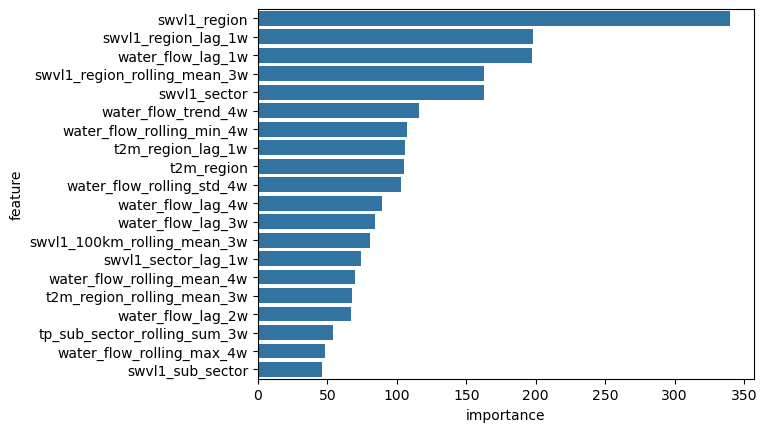

In [31]:
feat_import = pd.DataFrame({'feature': X_new.columns, 'importance': sfm.estimator_.feature_importances_})
feat_import = feat_import.sort_values('importance', ascending = False)
feat_import = feat_import[feat_import.importance >= 0]
sns.barplot(feat_import.iloc[:20], x = 'importance', y = 'feature')
feat_import.shape

(220, 2)

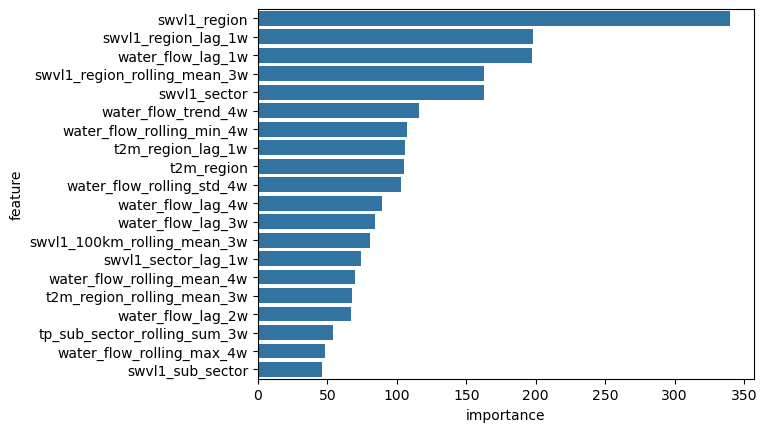

In [32]:
feat_import = pd.DataFrame({'feature': X_new.columns, 'importance': sfm.estimator_.feature_importances_})
feat_import = feat_import.sort_values('importance', ascending = False)
feat_import = feat_import[feat_import.importance >= 0]
sns.barplot(feat_import.iloc[:20], x = 'importance', y = 'feature')
feat_import.shape

(220, 2)

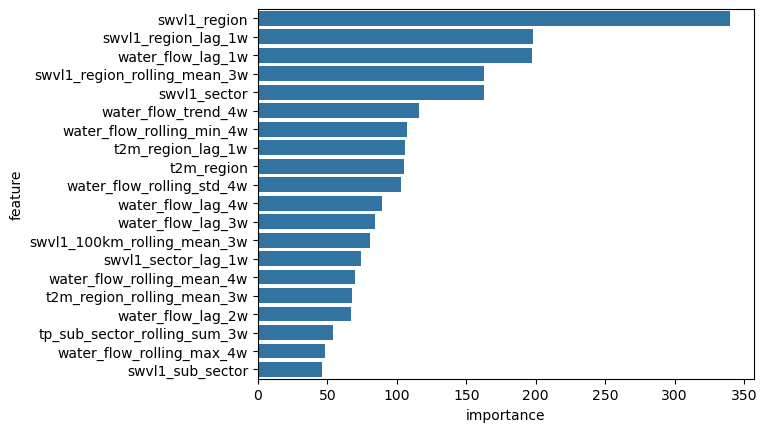

In [33]:
feat_import = pd.DataFrame({'feature': X_new.columns, 'importance': sfm.estimator_.feature_importances_})
feat_import = feat_import.sort_values('importance', ascending = False)
feat_import = feat_import[feat_import.importance >= 0]
sns.barplot(feat_import.iloc[:20], x = 'importance', y = 'feature')
feat_import.shape

In [34]:
selected_features_ = list(sfm.get_feature_names_out())
X_train = df[selected_features_ + CATEGORICAL + ['year', 'latitude', 'longitude', 'river_ranking'] + COLS_TO_DROP]
y_train = df[TARGET_COLS]

In [35]:
X_train.shape, y_train.shape

((28509, 42), (28509, 4))

In [36]:
selected_features_

['swvl1_region_rolling_mean_3w',
 'swvl1_sub_sector',
 'swvl1_region',
 'swvl1_region_lag_1w',
 't2m_region_rolling_mean_3w',
 't2m_region_lag_1w',
 'swvl1_sector',
 't2m_region',
 'swvl1_sector_lag_1w',
 'tp_sub_sector_rolling_sum_3w',
 'swvl1_100km_rolling_mean_3w',
 'water_flow_lag_1w',
 'water_flow_lag_2w',
 'water_flow_lag_3w',
 'water_flow_lag_4w',
 'water_flow_rolling_mean_4w',
 'water_flow_rolling_std_4w',
 'water_flow_rolling_min_4w',
 'water_flow_rolling_max_4w',
 'water_flow_trend_4w']

In [37]:
gbt_transformer = ColumnTransformer(
    [
        ('scaler', MinMaxScaler(), list(X_train.drop(columns = CATEGORICAL + COLS_TO_DROP + TARGET_COLS + [i for i in X_train.columns if 'water_flow_lag' in i or 'water_flow_rolling' in i] + ['river_ranking'], errors = 'ignore').columns) ),   
        ('drop_cols', 'drop', COLS_TO_DROP)
    ],
    remainder = 'passthrough'
)

### hyp tuning

In [38]:
val_years = [1992, 1995, 1988, 2001]
X_train_part = X_train[~X_train.year.isin(val_years)] 
X_val_part = X_train[X_train.year.isin(val_years)]
y_train_part = y_train.loc[X_train_part.index].iloc[:, 0]
y_val_part = y_train.loc[X_val_part.index].iloc[:, 0]

X_train_part = X_train_part.drop(columns = COLS_TO_DROP, errors = 'ignore')
X_val_part = X_val_part.drop(columns = COLS_TO_DROP, errors = 'ignore')

In [48]:
# 🔍 Objective function for Optuna
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'max_leaves': trial.suggest_int('max_leaves', 31, 64),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),

        'grow_policy': 'Lossguide',
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'task_type': 'CPU',  # Set to 'GPU' if you have GPU support
        'random_seed': 42,\
        'bootstrap_type': 'Bayesian'
    }

    train_pool = cb.Pool(X_train_part, y_train_part, cat_features=CATEGORICAL)
    val_pool = cb.Pool(X_val_part, y_val_part, cat_features=CATEGORICAL)

    model = cb.CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    preds = model.predict(X_val_part)
    # rmse = mean_squared_error(y_val_part, preds, squared=False)
    mae = mean_absolute_error(y_val_part, preds)
    return mae

In [49]:
# optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# best parameters
print("Best trial:")
print(f"  Value (MAE): {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

[I 2025-04-19 14:47:39,432] A new study created in memory with name: no-name-b829cf92-c211-47c3-9955-9c2b8d335778
[I 2025-04-19 14:47:48,956] Trial 0 finished with value: 18.08705084617642 and parameters: {'learning_rate': 0.10217420909545233, 'depth': 4, 'l2_leaf_reg': 0.018770694268082623, 'min_data_in_leaf': 42, 'random_strength': 0.5407081633887236, 'bagging_temperature': 1.3729487182493656, 'border_count': 94, 'max_leaves': 38, 'one_hot_max_size': 6}. Best is trial 0 with value: 18.08705084617642.
[I 2025-04-19 14:47:57,372] Trial 1 finished with value: 18.188182815604126 and parameters: {'learning_rate': 0.10521688519317336, 'depth': 12, 'l2_leaf_reg': 0.026520542266788096, 'min_data_in_leaf': 78, 'random_strength': 1.4641149195871381, 'bagging_temperature': 0.37208309069367784, 'border_count': 86, 'max_leaves': 63, 'one_hot_max_size': 8}. Best is trial 0 with value: 18.08705084617642.
[I 2025-04-19 14:48:05,416] Trial 2 finished with value: 18.21310531160287 and parameters: {'le

KeyboardInterrupt: 

### Test KMeans

In [45]:
sta = X_train.groupby(['station_code', 'latitude', 'longitude', 'river'])[[i for i in X_train.columns if 'water_flow' in i and 'trend' not in i]].agg(['mean', 'std']).reset_index()

In [46]:
sta_test = df_test.drop(columns = 'water_flow_trend_4w').groupby(['station_code', 'latitude', 'longitude', 'river'])[[i for i in X_train.columns if 'water_flow' in i and 'trend' not in i]].agg(['mean', 'std']).reset_index()

In [47]:
wcss = []
distortions = []
for k in range(2, 20):
    km = KMeans(k, random_state = 42)
    data = sta.drop(columns = ['station_code', 'river'])
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    km.fit(data)
    wcss.append(km.inertia_)
    distortions.append(sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)**2) / sta.shape[0])    

/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_code', 'river'])
/tmp/ipykernel_121860/824953812.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = sta.drop(columns = ['station_co

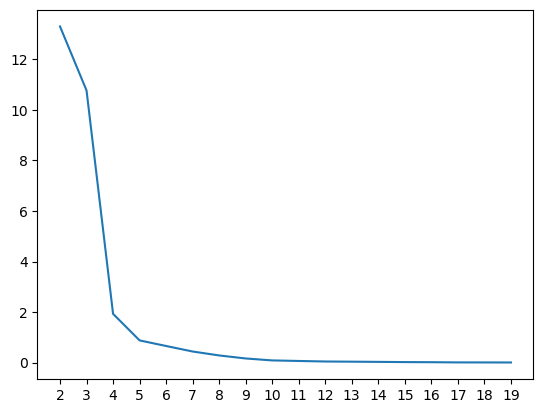

In [48]:
plt.plot([str(i) for i in range(2, 20)], wcss)

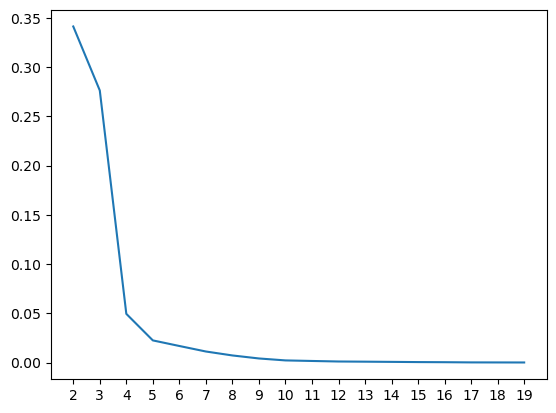

In [49]:
plt.plot([str(i) for i in range(2, 20)], distortions)

In [50]:
km = KMeans(12, random_state = 42)
km.fit(data)

KMeans(n_clusters=12, random_state=42)

In [51]:
km.labels_

array([ 8,  8, 10, 10,  8,  9, 10, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  4,  9,  0,  0,  0,  0,  0,  0,  0,  5,  6, 11,  2,  3,
        7, 11,  2,  2,  1], dtype=int32)

In [52]:
sta['cluster'] = km.labels_
sta.cluster = sta.cluster.astype(str)

<Axes: xlabel="('longitude', '')", ylabel="('latitude', '')">

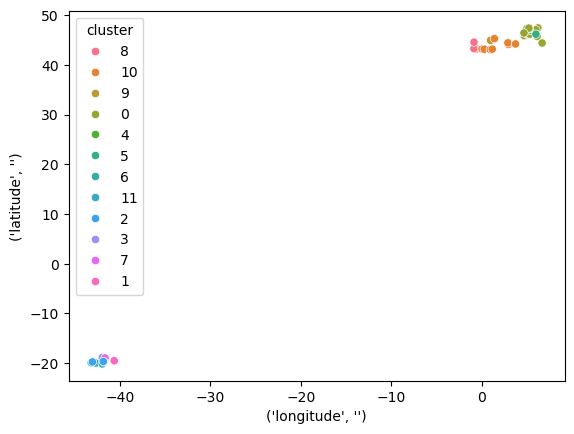

In [53]:
sns.scatterplot(sta, x = sta.columns[2], y = sta.columns[1], hue = 'cluster')

In [54]:
sta

station_code   latitude  longitude                   river  \
                                                                
0       6119020  43.187673  -0.597133            GAVE D'OSSAU   
1       6119040  43.245943  -0.874859                  SAISON   
2       6119110  43.174601   0.021673                   ECHEZ   
3       6119120  43.130613   0.258760                   ARROS   
4       6119200  44.547197  -0.872012                   LEYRE   
5       6124501  44.903011   0.959108                  VEZERE   
6       6124510  45.261184   1.380188                  ROSEIX   
7       6125220  43.045302   0.928175                   ARBAS   
8       6125320  44.080767   2.921202                    MUZE   
9       6125440  43.143790   1.141343                    VOLP   
10      6125630  44.414793   2.871969                   SERRE   
11      6139061  44.190360   3.715498  GARDON DE SAINTE-CROIX   
12      6139261  44.383261   6.651729                   UBAYE   
13      6139360  45.873299   4.642701                AZERGUES   
14      6139361  45.857683   4.687041                AZERGUES   
15      6139520  46.647213   5.774708                HERISSON   
16      6139550  46.155892   4.996680                   RENON   
17      6139560  46.118646   5.198074                   VEYLE   
18      6139640  46.170688   5.289284               REYSSOUZE   
19      6139681  47.414957   6.180271                   OGNON   
20      6139770  46.921595   5.350136                   DOUBS   
21      6139790  47.042646   5.814381                    LOUE   
22      6139795  47.030753   5.956855                   LISON   
23      6139825  45.719755   6.102802                  CHERAN   
24      6139900  47.237003   5.220392                  NORGES   
25      6139910  47.331788   4.980221                   OUCHE   
26      6139920  47.279504   5.216943                   TILLE   
27      6139921  47.372137   5.188617                   TILLE   
28      6139940  46.403242   4.648328                  GROSNE   
29      6939050  46.153000   5.970700                   RHONE   
30     56425000 -19.994400 -42.674400                RIO DOCE   
31     56610000 -19.931700 -43.173100          RIO PIRACICABA   
32     56659998 -19.765600 -43.032800          RIO PIRACICABA   
33     56850000 -18.883100 -41.950800                RIO DOCE   
34     56920000 -18.971100 -41.641700                RIO DOCE   
35     56960005 -20.170600 -41.961100            RIO MANHUAÇU   
36     56976000 -19.743100 -41.785300            RIO MANHUAÇU   
37     56978000 -19.678600 -41.835800            RIO MANHUAÇU   
38     56994500 -19.533300 -40.629700                RIO DOCE   

   water_flow_lag_1w             water_flow_lag_2w              \
                mean         std              mean         std   
0          18.013436   13.067202         18.002154   13.071798   
1          22.798011   20.811791         22.754460   20.814532   
2           1.221014    1.106043          1.219644    1.106430   
3           3.326129    3.272375          3.321516    3.273591   
4          16.565077   14.689473         16.548929   14.693359   
5          60.161827   54.168896         60.087018   54.199168   
6           0.654003    0.980855          0.652811    0.981101   
7           1.673061    1.797964          1.669682    1.798371   
8           1.384591    1.758144          1.377878    1.753229   
9           0.943738    1.487843          0.941736    1.487996   
10          0.990531    1.237126          0.989708    1.237466   
11          0.932945    1.730151          0.931235    1.730217   
12         10.447370   10.236737         10.445927   10.237870   
13          3.795723    5.251102          3.789290    5.252095   
14          7.032111    9.616759          7.021525    9.618797   
15          1.672975    1.689596          1.670839    1.690106   
16          0.746188    1.119906          0.745527    1.120127   
17          0.387538    0.443618          0.387216    0.443738   
18          0.576

In [55]:
sta_test['cluster'] = km.predict(scaler.transform(sta_test.drop(columns = ['station_code', 'river'])))
sta_test

/tmp/ipykernel_121860/807816236.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sta_test['cluster'] = km.predict(scaler.transform(sta_test.drop(columns = ['station_code', 'river'])))


station_code   latitude  longitude                   river  \
                                                                
0       6119020  43.187673  -0.597133            GAVE D'OSSAU   
1       6119030  43.197936  -0.608472           GAVE D'OLORON   
2       6119040  43.245943  -0.874859                  SAISON   
3       6119110  43.174601   0.021673                   ECHEZ   
4       6119120  43.130613   0.258760                   ARROS   
5       6119200  44.547197  -0.872012                   LEYRE   
6       6124501  44.903011   0.959108                  VEZERE   
7       6124510  45.261184   1.380188                  ROSEIX   
8       6124520  45.305197   1.414628                   LOYRE   
9       6125220  43.045302   0.928175                   ARBAS   
10      6125230  42.898226   1.231332                    ARAC   
11      6125320  44.080767   2.921202                    MUZE   
12      6125440  43.143790   1.141343                    VOLP   
13      6125630  44.414793   2.871969                   SERRE   
14      6125730  42.866371   0.746485                  MAUDAN   
15      6128630  43.185590   6.111176             REAL MARTIN   
16      6139061  44.190360   3.715498  GARDON DE SAINTE-CROIX   
17      6139261  44.383261   6.651729                   UBAYE   
18      6139360  45.873299   4.642701                AZERGUES   
19      6139361  45.857683   4.687041                AZERGUES   
20      6139520  46.647213   5.774708                HERISSON   
21      6139550  46.155892   4.996680                   RENON   
22      6139560  46.118646   5.198074                   VEYLE   
23      6139640  46.170688   5.289284               REYSSOUZE   
24      6139680  47.801835   6.666987                   OGNON   
25      6139681  47.414957   6.180271                   OGNON   
26      6139682  47.292297   5.544409                   OGNON   
27      6139770  46.921595   5.350136                   DOUBS   
28      6139790  47.042646   5.814381                    LOUE   
29      6139795  47.030753   5.956855                   LISON   
30      6139825  45.719755   6.102802                  CHERAN   
31      6139832  46.282056   5.921547               VALSERINE   
32      6139900  47.237003   5.220392                  NORGES   
33      6139910  47.331788   4.980221                   OUCHE   
34      6139920  47.279504   5.216943                   TILLE   
35      6139921  47.372137   5.188617                   TILLE   
36      6139930  47.747451   6.075586                LANTERNE   
37      6139940  46.403242   4.648328                  GROSNE   
38      6939050  46.153000   5.970700                   RHONE   
39     56425000 -19.994400 -42.674400                RIO DOCE   
40     56539000 -19.776900 -42.476400                RIO DOCE   
41     56610000 -19.931700 -43.173100          RIO PIRACICABA   
42     56659998 -19.765600 -43.032800          RIO PIRACICABA   
43     56688080 -19.646100 -42.850000          RIO PIRACICABA   
44     56696000 -19.524700 -42.640800          RIO PIRACICABA   
45     56719998 -19.329700 -42.376100                RIO DOCE   
46     56850000 -18.883100 -41.950800                RIO DOCE   
47     56920000 -18.971100 -41.641700                RIO DOCE   
48     56960005 -20.170600 -41.961100            RIO MANHUAÇU   
49     56976000 -19.743100 -41.785300            RIO MANHUAÇU   
50     56978000 -19.678600 -41.835800            RIO MANHUAÇU   
51     56990000 -19.492500 -41.161700            RIO MANHUAÇU   
52     56992400 -19.500800 -40.918600                RIO DOCE   
53     56994500 -19.533300 -40.629700                RIO DOCE   

   water_flow_lag_1w             water_flow_lag_2w               \
                mean         std              mean          std   
0          16.830989   14.331289         14.858571    11.608076   
1          49.520165   41.511144         41.833516    31.670148   
2          22.089890   24.227082         15.850659    14.195074   
3           1.221104    1.3

In [56]:
pd.concat([sta.set_index('station_code').cluster, sta_test.set_index('station_code').cluster], axis = 1)

,cluster,cluster
station_code,,
6119020,8,8
6119040,8,8
6119110,10,10
6119120,10,10
6119200,8,8
6124501,9,9
6124510,10,10
6125220,10,10
6125320,10,10


### Model 1 - Direct GBT

In [50]:
GBT_MODEL_PARAMS = {
    'iterations' : 1000,
    # 'learning_rate': 0.058572845809782996, 
    'depth': 10, 
    'l2_leaf_reg': 0.15520678413347222, 
    'min_data_in_leaf': 87, 
    # 'subsample': 0.7974433015972871, 
    'random_strength': 0.5878083922279745, 
    'bagging_temperature': 1.5885567609520757, 
    'border_count': 233,
    'grow_policy': 'Lossguide',
    'max_leaves': 39, 
    'one_hot_max_size': 2, #32,
    # 'od_wait' : 100,
    'od_type': 'Iter',
    'verbose':100,
    'bootstrap_type': 'Bayesian'
}

In [51]:
gbt_model = GBTEnsembleRegressor(
    model_fn = create_gbt_model,
    model_params = GBT_MODEL_PARAMS,
    preprocessor = gbt_transformer,
    cv = 5, 
    cv_group = 'year', 
    alphas = [0.05, 0.95], 
    method = 'indirect',
    n_models = 15,
    cat_features = CATEGORICAL, #['location', 'station_code'], #
    exclude_cols = COLS_TO_DROP,
    model_type = 'catboost',
    bootstrap = False,
    random_state = 42,
    delta = 0.01,
    patience = 100,
    min_patience = 20,
    lr = [0.05 for _ in range(15)], #[0.05, 0.05, 0.05,  0.05, 0.05, 0.05, 0.05,  0.05, 0.05, 0.05],
    # lr = [0.3,  0.15, 0.05, 0.15, 0.3],
    # lr = [0.05, 0.05, 0.05],
    split_type = 'time_series', #'group_kfold'
    chained = True, 
    use_priors = True,
    enforce_location = False,
    location_column = 'location',
    k = 12,
)

In [52]:
%%time
gbt_model.fit(X_train, y_train)

/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 74.8275910	test: 70.8160301	best: 70.8160301 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 13.9758075	test: 16.9373741	best: 16.9373741 (100)	total: 2.05s	remaining: 18.2s
200:	learn: 12.5392649	test: 16.6075542	best: 16.5292203 (185)	total: 4s	remaining: 15.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.52922033
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 74.5625506	test: 70.5978791	best: 70.5978791 (0)	total: 14.9ms	remaining: 14.9s
100:	learn: 17.5705442	test: 21.2954161	best: 21.2888917 (95)	total: 2.46s	remaining: 21.9s
200:	learn: 15.9280616	test: 20.8341168	best: 20.8292727 (199)	total: 4.97s	remaining: 19.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.75183356
bestIteration = 238

Shrink model to fi

/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 74.0543233	test: 71.6405966	best: 71.6405966 (0)	total: 11.9ms	remaining: 11.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.78348641
bestIteration = 78

Shrink model to first 79 iterations.
0:	learn: 67.3957329	test: 64.5915984	best: 64.5915984 (0)	total: 14.1ms	remaining: 14.1s
100:	learn: 17.7880806	test: 21.3884897	best: 21.3588381 (83)	total: 2.75s	remaining: 24.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 21.35883806
bestIteration = 83

Shrink model to first 84 iterations.
0:	learn: 73.0498571	test: 69.9907171	best: 69.9907171 (0)	total: 17.1ms	remaining: 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.60339501
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 72.5783693	test: 69.4561335	best: 69.4561335 (0)	total: 16ms	remaining: 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.8727261
bestIteration = 73

Shrink model to first 

/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 74.0934628	test: 70.2980490	best: 70.2980490 (0)	total: 27.7ms	remaining: 27.6s
100:	learn: 13.6866917	test: 16.0897206	best: 16.0897206 (100)	total: 2.81s	remaining: 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.94771655
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 73.9161506	test: 69.4657719	best: 69.4657719 (0)	total: 20.5ms	remaining: 20.5s
100:	learn: 17.8820290	test: 20.2208262	best: 20.2208262 (100)	total: 2.6s	remaining: 23.1s
200:	learn: 16.2071944	test: 19.7956959	best: 19.7935105 (197)	total: 4.86s	remaining: 19.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.79250539
bestIteration = 201

Shrink model to first 202 iterations.
0:	learn: 73.3357240	test: 68.6475870	best: 68.6475870 (0)	total: 13.5ms	remaining: 13.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.24362086
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 72.39

/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 72.0691984	test: 76.1125906	best: 76.1125906 (0)	total: 23.3ms	remaining: 23.2s
100:	learn: 13.4588683	test: 16.4580376	best: 16.4580376 (100)	total: 3.08s	remaining: 27.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.17288119
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 72.4001814	test: 74.4111868	best: 74.4111868 (0)	total: 18ms	remaining: 17.9s
100:	learn: 17.3503983	test: 20.4336786	best: 20.4204544 (99)	total: 3.29s	remaining: 29.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.05029213
bestIteration = 165

Shrink model to first 166 iterations.
0:	learn: 71.9618476	test: 73.5815554	best: 73.5815554 (0)	total: 15ms	remaining: 14.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.96450716
bestIteration = 44

Shrink model to first 45 iterations.
0:	learn: 72.6002286	test: 73.2233522	best: 73.2233522 (0)	total: 16.8ms	remaining: 16.8s
Stopped by overfitti

/tmp/ipykernel_1062651/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 73.4407450	test: 71.0269787	best: 71.0269787 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 13.8016730	test: 13.6945297	best: 13.6909507 (92)	total: 2.28s	remaining: 20.3s
200:	learn: 12.5469430	test: 12.9787250	best: 12.9787250 (200)	total: 4.57s	remaining: 18.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 12.97003453
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 70.9664392	test: 66.7696364	best: 66.7696364 (0)	total: 12.6ms	remaining: 12.5s
100:	learn: 17.7610625	test: 18.9887116	best: 18.9453181 (84)	total: 3.39s	remaining: 30.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 18.42277823
bestIteration = 131

Shrink model to first 132 iterations.
0:	learn: 72.9548953	test: 65.2616440	best: 65.2616440 (0)	total: 15.2ms	remaining: 15.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 24.60876241
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 74.3

In [41]:
%%time
gbt_model.fit(X_train, y_train)

/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 73.6608349	test: 69.6335271	best: 69.6335271 (0)	total: 72.4ms	remaining: 1m 12s
100:	learn: 11.5400524	test: 15.9922930	best: 15.9922930 (100)	total: 1.75s	remaining: 15.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.56984839
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 73.9834690	test: 70.0022106	best: 70.0022106 (0)	total: 13.5ms	remaining: 13.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.3903851
bestIteration = 47

Shrink model to first 48 iterations.
0:	learn: 65.5890640	test: 62.3842006	best: 62.3842006 (0)	total: 29.7ms	remaining: 29.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.72912948
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 72.3917178	test: 67.54

/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 74.0761364	test: 71.6511730	best: 71.6511730 (0)	total: 13.9ms	remaining: 13.9s
100:	learn: 11.7280415	test: 16.0553620	best: 16.0553620 (100)	total: 2.6s	remaining: 23.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.99818279
bestIteration = 125

Shrink model to first 126 iterations.
0:	learn: 61.1282533	test: 59.0045081	best: 59.0045081 (0)	total: 14.9ms	remaining: 14.9s
100:	learn: 15.8693028	test: 20.2621003	best: 20.2549912 (98)	total: 1.92s	remaining: 17.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.15670289
bestIteration = 133

Shrink model to first 134 iterations.
0:	learn: 73.1066179	test: 70.0311882	best: 70.0311882 (0)	total: 12.1ms	remaining: 12.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.98977622
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 72.5828602	test: 69.6919364	best: 69.6919364 (0)	total: 17.2ms	remaining: 17.2s
Stopped by overfi

/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 73.3081077	test: 69.8008990	best: 69.8008990 (0)	total: 23.5ms	remaining: 23.4s
100:	learn: 12.2427237	test: 15.8228850	best: 15.8195671 (99)	total: 2.83s	remaining: 25.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.78928661
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 73.6011875	test: 69.1709283	best: 69.1709283 (0)	total: 11.2ms	remaining: 11.2s
100:	learn: 15.9842354	test: 20.4780575	best: 20.4324912 (85)	total: 4.75s	remaining: 42.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.43249122
bestIteration = 85

Shrink model to first 86 iterations.
0:	learn: 73.3378386	test: 68.6082743	best: 68.6082743 (0)	total: 15.7ms	remaining: 15.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.88374241
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 71.2289414	test: 63.8855250	best: 63.8855250 (0)	total: 43.4ms	remaining: 43.4s
Stopped by overfitt

/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 72.5698756	test: 76.5651377	best: 76.5651377 (0)	total: 11.8ms	remaining: 11.8s
100:	learn: 12.0585687	test: 17.0085600	best: 17.0063034 (98)	total: 2.12s	remaining: 18.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.92654058
bestIteration = 132

Shrink model to first 133 iterations.
0:	learn: 72.1250859	test: 74.2482034	best: 74.2482034 (0)	total: 18.3ms	remaining: 18.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.79405054
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 72.0020996	test: 73.6201209	best: 73.6201209 (0)	total: 24ms	remaining: 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.18745507
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 68.5395328	test: 69.0650606	best: 69.0650606 (0)	total: 16.2ms	remaining: 16.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 30.31735305
bestIteration = 36

Shrink model to f

/tmp/ipykernel_1038135/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 73.4404069	test: 71.0310247	best: 71.0310247 (0)	total: 11.7ms	remaining: 11.6s
100:	learn: 12.1659419	test: 14.4423086	best: 14.4423086 (100)	total: 2.08s	remaining: 18.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 14.21377802
bestIteration = 159

Shrink model to first 160 iterations.
0:	learn: 73.3685794	test: 69.0841599	best: 69.0841599 (0)	total: 13.2ms	remaining: 13.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 21.1078705
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 73.3814674	test: 65.6610442	best: 65.6610442 (0)	total: 16.6ms	remaining: 16.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 24.93602692
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 73.3542983	test: 60.6206926	best: 60.6206926 (0)	total: 17.3ms	remaining: 17.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 22.87486533
bestIteration = 12

Shrink model 

In [94]:
%%time
gbt_model.fit(X_train, y_train)

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 74.3407795	test: 70.3482845	best: 70.3482845 (0)	total: 11ms	remaining: 11s
100:	learn: 13.2697019	test: 16.6373305	best: 16.6342154 (95)	total: 1.5s	remaining: 13.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.45961427
bestIteration = 161

Shrink model to first 162 iterations.
0:	learn: 74.4530044	test: 70.5075428	best: 70.5075428 (0)	total: 9.23ms	remaining: 9.22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.25981425
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 74.4206798	test: 69.8184174	best: 69.8184174 (0)	total: 13.9ms	remaining: 13.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.14544834
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 74.1613184	test: 69.3810108	

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 73.8445162	test: 71.3934163	best: 71.3934163 (0)	total: 11.9ms	remaining: 11.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.67471792
bestIteration = 66

Shrink model to first 67 iterations.
0:	learn: 65.2482627	test: 63.8986777	best: 63.8986777 (0)	total: 11ms	remaining: 11s
100:	learn: 16.8616742	test: 19.4662832	best: 19.4161907 (86)	total: 3.1s	remaining: 27.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.41619065
bestIteration = 86

Shrink model to first 87 iterations.
0:	learn: 71.6666912	test: 69.3207961	best: 69.3207961 (0)	total: 23.6ms	remaining: 23.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.09430743
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 72.5546588	test: 69.6205684	best: 69.6205684 (0)	total: 22.7ms	remaining: 22.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.17994969
bestIteration = 43

Shrink model to firs

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 71.8574299	test: 68.0183709	best: 68.0183709 (0)	total: 18.9ms	remaining: 18.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.96779722
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 73.6687676	test: 69.1858439	best: 69.1858439 (0)	total: 12ms	remaining: 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.10150173
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 72.4384754	test: 67.8591066	best: 67.8591066 (0)	total: 16.3ms	remaining: 16.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.53662138
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 70.1661765	test: 65.3106994	best: 65.3106994 (0)	total: 60.9ms	remaining: 1m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.21598491
bestIteration = 59

Shrink model to first 60 iterations.
----------------------------------------------------
Training model fold_2_mo

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 71.8162792	test: 75.8330152	best: 75.8330152 (0)	total: 13.9ms	remaining: 13.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 17.52041914
bestIteration = 77

Shrink model to first 78 iterations.
0:	learn: 61.3850570	test: 63.5399178	best: 63.5399178 (0)	total: 15.3ms	remaining: 15.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.89970563
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 69.0863583	test: 70.6492569	best: 70.6492569 (0)	total: 22.4ms	remaining: 22.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.73501394
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 60.0545246	test: 60.6810685	best: 60.6810685 (0)	total: 14.8ms	remaining: 14.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 29.18336163
bestIteration = 36

Shrink model to first 37 iterations.
----------------------------------------------------
Training model fo

/tmp/ipykernel_917805/2800315667.py:454: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 73.2397350	test: 70.8851475	best: 70.8851475 (0)	total: 24.7ms	remaining: 24.7s
100:	learn: 13.4502971	test: 15.6509484	best: 15.6509484 (100)	total: 4.28s	remaining: 38.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.58007401
bestIteration = 104

Shrink model to first 105 iterations.
0:	learn: 69.8761194	test: 66.3669748	best: 66.3669748 (0)	total: 20.9ms	remaining: 20.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.81180304
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 69.8720919	test: 62.2416474	best: 62.2416474 (0)	total: 21.4ms	remaining: 21.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 23.83835801
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 73.0023994	test: 60.3140869	best: 60.3140869 (0)	total: 19.3ms	remaining: 19.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 22.51256316
bestIteration = 16

Shrink model

##### Save and load model for inference

In [85]:
TIMESTAMP = datetime.datetime.now().strftime('%Y%m%dT%H%M')
METHOD = 'model_36_indirect_finetune_bayesian_bootstrap'
VER = 1

In [86]:
save_path = f'./saved_models/{TIMESTAMP}_GBT_{METHOD}_{VER}'
# save_path = './saved_models/20250414T0831_GBT_direct_TT_3'

In [84]:
gbt_model.save_model(save_path)

In [53]:
model = gbt_model

In [74]:
model = GBTEnsembleRegressor(use_priors = True, enforce_location = False)
model.load_model(save_path, create_gbt_model, GBT_MODEL_PARAMS)

In [54]:
feat_importances = model.get_feature_importances_()

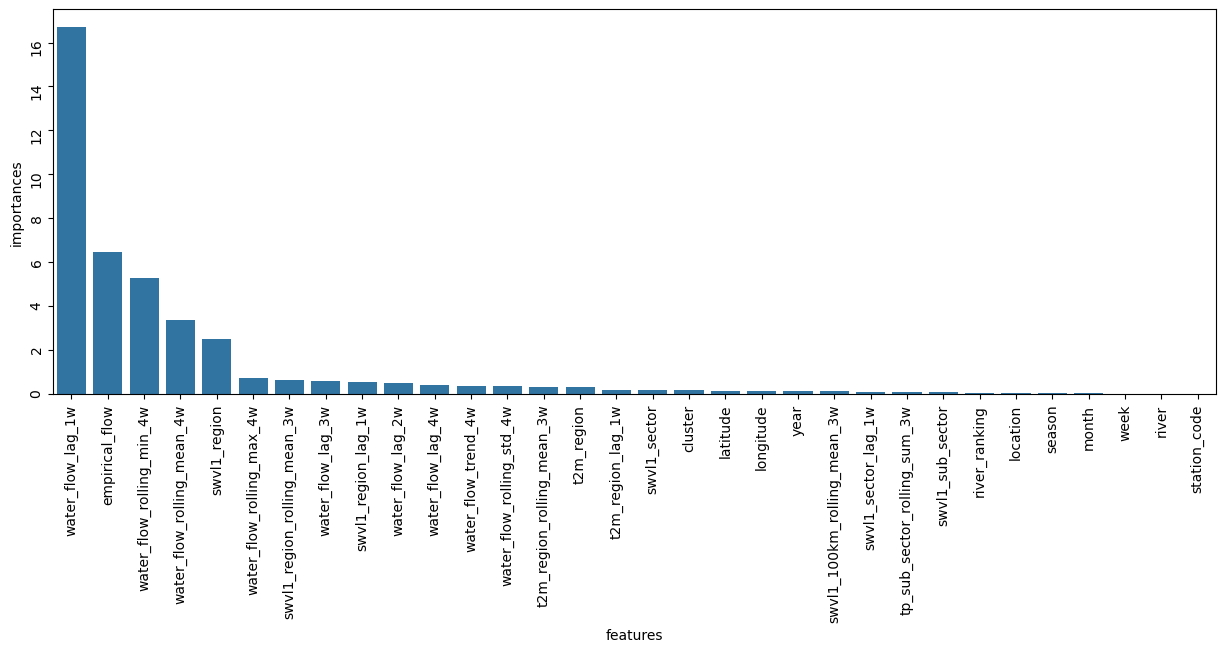

In [55]:
plt.figure(figsize = (15, 5))
sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
plt.tick_params(rotation = 90)

In [56]:
np.mean(list(model.results.values()))

1.7105327759924118

In [57]:
# X_train.water_flow_lag_1w.mean(), df_test.water_flow_lag_1w.mean()

In [58]:
X_train.shape, df_test.shape

((28509, 42), (1390, 654))

In [59]:
# set(X_train.columns).symmetric_difference(df_test.columns)

In [60]:
# X_train.columns

In [61]:
X_test = df_test.drop(columns = 'dataset')
# X_test = X_test.drop(columns = X_train.columns)
X_test = X_test[X_train.columns]

In [62]:
X_test.columns

Index(['swvl1_region_rolling_mean_3w', 'swvl1_sub_sector', 'swvl1_region',
       'swvl1_region_lag_1w', 't2m_region_rolling_mean_3w',
       't2m_region_lag_1w', 'swvl1_sector', 't2m_region',
       'swvl1_sector_lag_1w', 'tp_sub_sector_rolling_sum_3w',
       'swvl1_100km_rolling_mean_3w', 'water_flow_lag_1w', 'water_flow_lag_2w',
       'water_flow_lag_3w', 'water_flow_lag_4w', 'water_flow_rolling_mean_4w',
       'water_flow_rolling_std_4w', 'water_flow_rolling_min_4w',
       'water_flow_rolling_max_4w', 'water_flow_trend_4w', 'river', 'location',
       'month', 'week', 'season', 'station_code', 'year', 'latitude',
       'longitude', 'river_ranking', 'ObsDate', 'catchment', 'hydro_region',
       'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector',
       'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone',
       'sub_sector_zone'],
      dtype='object')

In [63]:
# X_test.week.dtype, X_test.shape, X_train.shape

In [64]:
%%time
res, _ = model.predict(X_test)

/tmp/ipykernel_1062651/2800315667.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_1062651/2800315667.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['weights'] = weights
/tmp/ipykernel_1062651/2800315667.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[84.83499871 78.68907882 74.84351829 72.64697583]
[89.05523608 82.98222518 75.13061239 75.12244758]
[88.74961247 80.76922955 77.44589339 75.06644439]
[87.11321851 81.81064174 78.50208012 73.45180527]
[90.50018263 82.24206662 76.65714627 74.43807108]
[90.65700022 83.28751344 76.3708405  72.67542824]
[89.47145932 81.04983747 75.94545414 74.46521359]
[88.85512396 78.163887   74.06695761 73.18552886]
[89.56766434 83.20152254 76.04546402 73.24665128]
[87.63857302 83.11661578 74.97120339 74.20677191]
[90.21106653 83.2775697  77.17504201 76.40369521]
[89.59195508 81.88282295 75.80555397 74.32631795]
[87.63483203 80.92010553 77.34089781 72.40338711]
[85.85036619 78.89529067 74.72661325 73.84257094]
[88.46149213 80.5988943  76.24220901 73.90026571]
[88.33102888 80.5719159  76.31321726 71.64837112]
[87.56661273 80.78589488 74.22930884 72.40683604]
[87.28064452 81.35598901 76.67233838 74.11156197]
[89.13536996 82.34714732 75.9152926  70.65244199]
[86.4132861  84.93709392 76.39820946 72.64896628]


In [65]:
list(res.values())[0].shape

(1390, 4)

In [66]:
df_output = []
for key, value in res.items():
    temp = pd.DataFrame(value, columns = [f'week_{i}_{key}' for i in range(4)])
    df_output.append(temp)
df_output = pd.concat(df_output, axis = 1)
df_output = df_output.clip(0, np.inf)
df_output[df_output.filter(like = 'sup').columns] = df_output.filter(like = 'sup').astype('float') + 0.01
df_output[df_output.filter(like = 'inf').columns] = df_output.filter(like = 'inf').astype('float')# - 0.01
for i in range(0, 4):
    df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']] = np.sort(df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']].values, axis = 1)
df_output[['station_code', 'ObsDate']] = df_test[['station_code', 'ObsDate']]
key = ['pred', 'inf', 'sup']
df_output = df_output[['station_code'] + [f'week_{i}_{key[j]}' for i in range(4) for j in range(3)] + ['ObsDate']]

In [67]:
df_test.shape

(1390, 654)

In [68]:
df_output.station_code.nunique()

54

In [69]:
(df_output.week_1_sup - df_output.week_1_inf).mean()

109.89319243603332

In [70]:
X_ = X_train.reset_index(drop = True)

In [71]:
def compute_non_negative_log_likelihood(
    y_true,
    y_pred, 
    y_quantiles,
    station_codes,
    station_stats,
    alpha=.1
):
    """
    Custom log-likelihood scoring function.

    Parameters:
        y_pred : The predictions
        y_quantiles: Prediction Intervals
        y_true : True target values.
        cv_data : Full DataFrame that includes extra columns
        (e.g., "station_code").
        station_stats : Station-level statistics needed for standardization.
        alpha : Significance level (default from ALPHA).

    Returns:
        nll_s : Computed log-likelihood score.
    """
    # Standardize the values.
    y_true_std = standardize_values(
        y_true.to_numpy(),
        station_codes,
        station_stats)
    y_pred_std = standardize_values(
        y_pred,
        station_codes,
        station_stats)
    y_lower_std, y_upper_std = standardize_prediction_intervals(
        y_quantiles,
        station_codes,
        station_stats)

    # Compute sigma from the prediction interval.
    sigma_std = (y_upper_std - y_lower_std) / 3.29
    sigma_std = np.maximum(sigma_std, 1e-6)
    
    # Compute the negative log-likelihood.
    nll_s = (1 / len(y_true_std)) * np.sum(
        np.log(sigma_std) + np.abs(y_true_std - y_pred_std) / (2 * sigma_std)
    )

    # Optionally, print some diagnostics.
    cov = np.mean(
        (y_true_std >= y_lower_std) & (y_true_std <= y_upper_std))
    i_size = np.mean(y_upper_std - y_lower_std)
    print(
        f"Fold: coverage = {cov:.3f}, interval size = {i_size:.3f}")

    return nll_s

In [72]:
# n = 0
# y_true = y_train.iloc[:, n]
# y_pred = df_output.iloc[:, n]
# y_quantiles = df_output[[f'week_{n+1}_inf', f'week_{n+1}_sup']].values
# station_codes = X_train.station_code
# station_stats = get_station_stats(y_true, station_codes)

In [73]:
# np.abs(y_pred - y_true).mean()

In [74]:
# nll = compute_non_negative_log_likelihood(
#     y_true,
#     y_pred, 
#     y_quantiles,
#     station_codes,
#     station_stats,
#     alpha = 0.1
# )
# nll

In [75]:
# df.groupby('location').water_flow_week_1.quantile([0, 0.25, 0.5, 0.75, 1])

In [76]:
# df_test.groupby('location').station_code.nunique()

In [77]:
X_train.shape

(28509, 42)

In [78]:
set(X_train.station_code).symmetric_difference(set(X_test.station_code))

{'56539000',
 '56688080',
 '56696000',
 '56719998',
 '56990000',
 '56992400',
 '6119030',
 '6124520',
 '6125230',
 '6125730',
 '6128630',
 '6139680',
 '6139682',
 '6139832',
 '6139930'}

6119020 GAVE D'OSSAU


/tmp/ipykernel_1062651/779844926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
/tmp/ipykernel_1062651/779844926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)


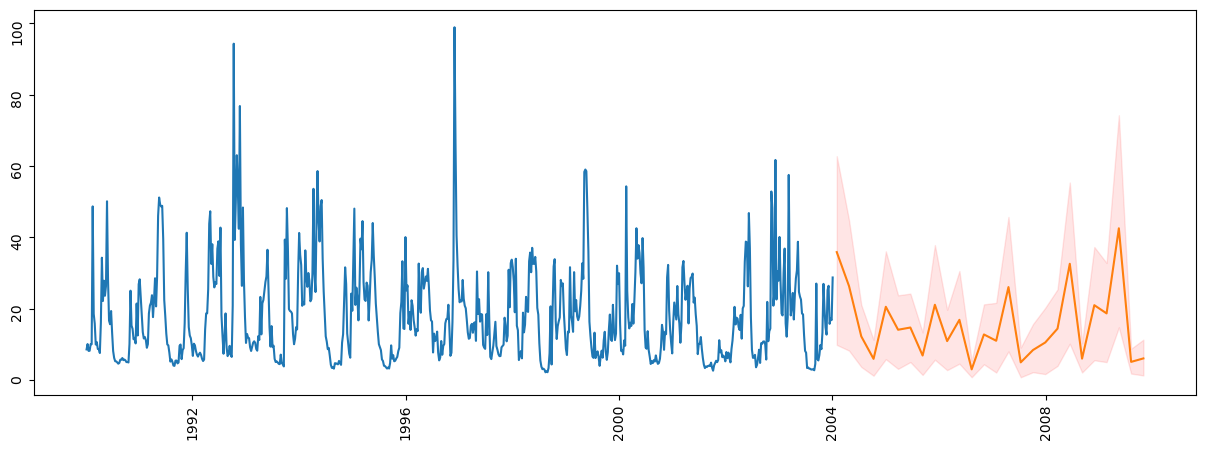

In [79]:
n = 0
j = 0 #12
station_codes = df_test.station_code.unique()
plt.figure(figsize = (15, 5))
samp_X = df_test[df_test.station_code == station_codes[j]] #'56610000'] #
samp_X_true = X_train[X_train.station_code == station_codes[j]]
samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)
samp_y_true = y_train.loc[samp_X_true.index]
pred_y = df_output.loc[samp_X.index]
plt.plot(samp_X_true.ObsDate, samp_y_true.iloc[:, n].values);
plt.plot(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_pred'])
plt.fill_between(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_inf'], pred_y.loc[:, f'week_{n+1}_sup'], color = 'red', alpha = 0.1)
plt.tick_params(rotation = 90)
print(station_codes[j], samp_X.river.unique()[0])

In [80]:
df_output.drop(columns = ['station_code', 'ObsDate']).mean()

week_0_pred     87.443218
week_0_inf      32.960481
week_0_sup     144.126636
week_1_pred     80.808358
week_1_inf      27.500472
week_1_sup     137.393664
week_2_pred     75.232432
week_2_inf      24.678874
week_2_sup     129.552037
week_3_pred     72.253062
week_3_inf      23.088731
week_3_sup     125.856194
dtype: float64

In [81]:
df_output.to_csv('predictions.csv', index = False)